In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import io
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
import os
import sklearn


from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from PIL import Image



In [17]:
# PATHs

data_path = r"C:\Users\Arthur\DESKTOP\skin-lesion-dataset\ISIC_2019_Training_Input"
metadata_path = r'C:\Users\Arthur\Desktop\skin-lesion-dataset\ISIC_2019_Training_Metadata\ISIC_2019_Training_Metadata.csv'
label_path = r'C:\Users\Arthur\Desktop\skin-lesion-dataset\ISIC_2019_Training_GroundTruth.csv'



In [3]:
# Make sure that the folder exists and contains files
if not os.path.exists(data_path):
    raise ValueError(f"Folder {data_path} does not exist.")
if len(os.listdir(data_path)) == 0:
    raise ValueError(f"Folder {data_path} is empty.")

# Load the images from the folder using load_files
dataset = load_files(data_path, shuffle=False)

# Make sure that some files were loaded
if len(dataset.filenames) == 0:
    raise ValueError(f"No files were loaded from folder {data_path}.")


Image size: 1022 x 767
Number of samples in dataset: 25331


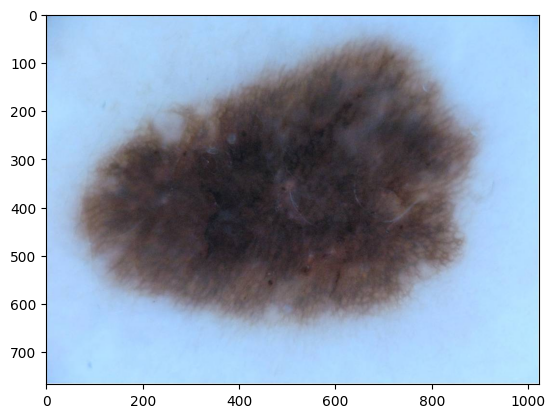

In [12]:
# Access the file paths of the images
filenames = dataset.filenames

# Load the first image using Pillow
img = Image.open(filenames[0])

# Convert the image to a numpy array for display
img_array = np.array(img)

# Get the size of the image
width, height = img.size

# Print the size of the image
print(f"Image size: {width} x {height}")

# Print the number of samples
print("Number of samples in dataset: {}".format(len(dataset.data)))

# Display the image using Matplotlib
plt.imshow(img_array)
plt.show()

In [33]:
# Load the images from the folder using load_files
metadata_df = pd.read_csv(metadata_path)
label_df = pd.read_excel(label_path)

# Get the number of rows and columns in the DataFrame
num_rows, num_cols = metadata_df.shape

# Print the metadata
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

metadata.head()

Number of rows: 25331
Number of columns: 5


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [36]:
label_df = pd.read_csv(label_path)

# Get the number of rows and columns in the DataFrame
num_rows, num_cols = label_df.shape

# Print the metadata
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

label_df.head()

Number of rows: 25331
Number of columns: 10


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
from torchvision.models import resnet18, ResNet18_Weights

In [42]:
# Load the pre-trained ResNet18 model
model = models.resnet18(weights=ResNet18_Weights)

# Freeze all layers of the model
for param in model.parameters():
    param.requires_grad = False


In [45]:
# the number of classses is the the number of columns - 1 
num_classes = label_df.shape[1] - 1
# Replace the last fully-connected layer of the model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [77]:
# Define the data transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize with ImageNet mean and std
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize with ImageNet mean and std
])


# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_path, transform=train_transforms)

## Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Training set size: {} images".format(len(train_dataset)))
print("Test set size: {} images".format(len(test_dataset)))

# Create the PyTorch data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)


Training set size: 20264 images
Test set size: 5067 images


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [72]:
# Train the model
for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics every 10 batches
        if (i + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test accuracy: {accuracy:.2f}%")

Epoch 1, Batch 10/167, Loss: 0.0001
Epoch 1, Batch 20/167, Loss: 0.0001
Epoch 1, Batch 30/167, Loss: 0.0003
Epoch 1, Batch 40/167, Loss: 0.0001
Epoch 1, Batch 50/167, Loss: 0.0002


KeyboardInterrupt: 